# Homework 4: Ising Spins

Consider $i = 1, \ldots, N$ spins taking values $S_i = \pm 1$, on a 2D grid of size $(L \times L)$, with $N = L^2$ and periodic boundary conditions. The Hamiltonian reads:

$$
H= - \displaystyle \sum_{\langle ij \rangle} s_i s_j
$$

where $\langle ij \rangle$ denote the complete set of links $i,j$ on the 2D grid. Use the convention $k_B = J = 1$, so that $\beta = 1/T$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
class lattice:
    def __init__(self, L, T, **kwargs):
        # initialize the 2D lattice in an ordered state if
        # key config is "ordered", and in a random state if
        # key config is "random". Default = "random".
        # Also define T and initialize two empty vectors to 
        # collect values  of energy and magnetization at 
        # each MCMC step.
        self.start_config = kwargs.get("config", "random")
        if self.start_config == "random":
            self.grid = np.random.choice([1, -1], [L, L])
        elif self.start_config == "ordered":
            self.grid = np.ones([L, L])
        self.beta = 1.0/T
        self.L = L
        self.energy = []
        self.magnetization = []
        
    def compute_energy(self):
        # compute the energy of a configuration as sum over neighbors
        # of the product of spins
        energy = 0
        for i in xrange(self.L):
            for j in xrange(self.L):
                energy -= self.grid[i][j]*(self.grid[i][(j+1) % (self.L)] + \
                  self.grid[i][(j-1) % (self.L)] + \
                  self.grid[(i+1)%self.L][j] + \
                  self.grid[(i-1)%self.L][j])
        return energy
                 
    def compute_magnetization(self):
        # compute the magnetization
        return np.sum(self.grid)
        
    def reset_observables(self):
        # reset energy and magnetization lists
        self.energy = []
        self.magnetization = []
    
    def MCMC(self, n_steps):
        # performs n_steps MCMC steps
        
        def delta_energy(grid, i, j):
            # computes delta energy between initial (a) and final state (b)
            # E(a) - E(b) as twice the contribution over neighbours (using 
            # PBC) of the spin which would be flipped.
            delta_E = -2*grid[i][j]*(grid[i][(j+1) % (self.L)] + \
                  grid[i][(j-1) % (self.L)] + \
                  grid[(i+1)%self.L][j] + \
                  grid[(i-1)%self.L][j])
            return delta_E
        
        for step in xrange(n_steps):
            # choose randomly a spin by extracting two indices
            ix, iy = np.random.randint(0, self.L, size = 2)
            
            # Metropolis
            delta_E = delta_energy(self.grid, ix, iy)
            # p is min(1, exp(beta*(E(a) - E(b))))
            p = min([1, np.exp(self.beta*delta_E)])
            # first check p > 1 to save a call to rand eventually
            if p > 1 or np.random.rand() < p:
                self.grid[ix][iy] *= -1
                
            self.energy.append(self.compute_energy())
            self.magnetization.append(self.compute_magnetization())
                
    def plot_lattice(self, **kwargs):
        self.title = kwargs.get("title", "")
        for i in xrange(self.L):
            for j in xrange(self.L):
                if self.grid[i][j] == 1:
                    plt.plot(i, j, "r^")
                else:
                    plt.plot(i, j, "bv")
        plt.xlim([-0.5, self.L - 0.5])
        plt.ylim([-0.5, self.L - 0.5])
        plt.title(self.title)
        plt.axes().set_aspect('equal')
        plt.show()

In [15]:
Ising_lowT = lattice(30, 0.5)

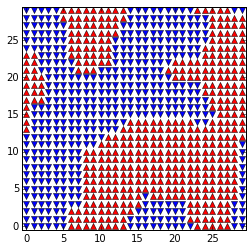

In [18]:
Ising_lowT.MCMC(10000)
Ising_lowT.plot_lattice()

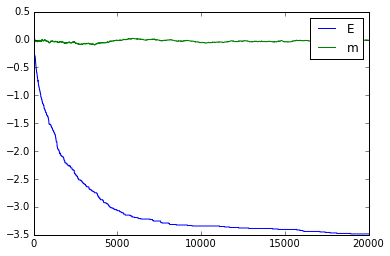

In [39]:
plt.plot(xrange(len(Ising_lowT.energy)), np.asarray(Ising_lowT.energy)/900.0, label = "E")
plt.plot(xrange(len(Ising_lowT.magnetization)), np.asarray(Ising_lowT.magnetization)/900.0, label="m")
plt.legend()
plt.show()

In [40]:
M = (np.sum(Ising_lowT.grid==1)-np.sum(Ising_lowT.grid==-1))/900.0
print M

-0.0133333333333


In [19]:
Ising_highT = lattice(30, 4)

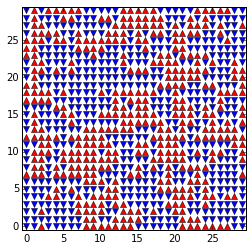

In [21]:
Ising_highT.MCMC(10000)
Ising_highT.plot_lattice()